In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import camera_calibration_show_extrinsics as show
from PIL import Image
corner_x = 7
corner_y = 7
objp = np.zeros((corner_x*corner_y,3), np.float32)
objp[:,:2] = np.mgrid[0:corner_x, 0:corner_y].T.reshape(-1,2)

find the chessboard corners of data\0000.jpg
find the chessboard corners of data\0001.jpg
find the chessboard corners of data\0002.jpg
find the chessboard corners of data\0003.jpg
find the chessboard corners of data\0004.jpg
find the chessboard corners of data\0005.jpg
find the chessboard corners of data\0006.jpg
find the chessboard corners of data\0007.jpg
find the chessboard corners of data\0008.jpg
find the chessboard corners of data\0009.jpg


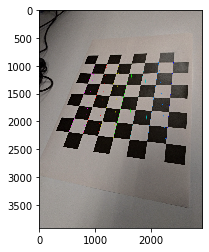

In [2]:
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('data/*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)

    #Find the chessboard corners
    print('find the chessboard corners of',fname)
    ret, corners = cv2.findChessboardCorners(gray, (corner_x,corner_y), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (corner_x,corner_y), corners, ret)
        plt.imshow(img)

In [3]:
from cv2 import findHomography
num_of_point = 49
Homography = []
objp = np.array([np.delete(p,2,1) for p in objpoints])
imgp = np.asarray(imgpoints).reshape(10,49,2)
for i in range(10):
    retval, mask = findHomography(objp[i],imgp[i])
    Homography.append(retval)

In [4]:
num_of_plane = 10
V = np.zeros((num_of_plane*2,6))
for i, homography in enumerate(Homography):
    if i == num_of_plane:
        break
    h1 = homography[:,0]
    h2 = homography[:,1]
    V12 = np.asarray([h1[0]*h2[0], h1[0]*h2[1]+h1[1]*h2[0], h1[1]*h2[1],
           h1[2]*h2[0]+h1[0]*h2[2],h1[2]*h2[1]+h1[1]*h2[2], h1[2]*h2[2]])
    V11 = np.asarray([h1[0]*h1[0], h1[0]*h1[1]+h1[1]*h1[0], h1[1]*h1[1],
           h1[2]*h1[0]+h1[0]*h1[2],h1[2]*h1[1]+h1[1]*h1[2], h1[2]*h1[2]])
    V22 = np.asarray([h2[0]*h2[0], h2[0]*h2[1]+h2[1]*h2[0], h2[1]*h2[1],
           h2[2]*h2[0]+h2[0]*h2[2],h2[2]*h2[1]+h2[1]*h2[2], h2[2]*h2[2]])
    V[2*i] = V12
    V[2*i+1] = V11 - V22
U2, D2, V2 = np.linalg.svd(V)
b = V2[-1]
B = np.zeros((3,3))
B[0][0], B[0][1], B[1][1], B[0][2], B[1][2], B[2][2] = b[0:6]
B[1][0], B[2][0], B[2][1] = B[0][1], B[0][2], B[1][2]
K_inv = np.transpose(np.linalg.cholesky(-1*B)) #inverse of intrinsic matrix

In [5]:
Extrinsics = np.zeros((num_of_plane,3,4))
for i, homography in enumerate(Homography):
    E = np.matmul(K_inv,homography) # lambda*K^-1 * H = [r1, r2, t]
    E = E / (E[0][0]**2 + E[1][0]**2 + E[2][0]**2)**0.5 # = [r1, r2, t]
    r1, r2, t = E[:,0], E[:,1], E[:,2]
    r3 = np.cross(r1,r2)
    Extrinsics[i][:,0],Extrinsics[i][:,1],Extrinsics[i][:,2],Extrinsics[i][:,3]=r1,r2,r3,t

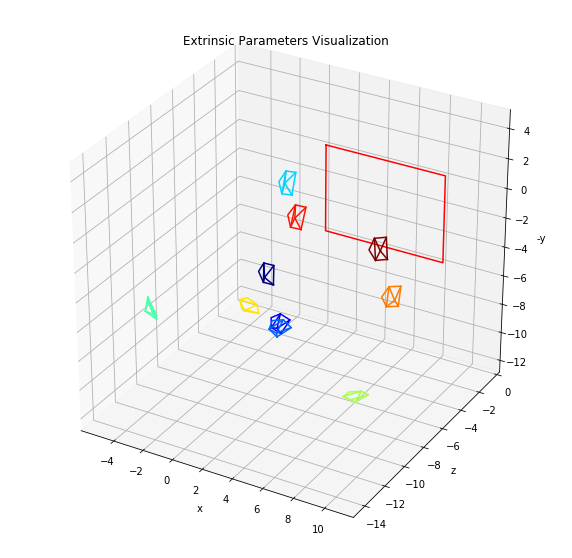

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# camera setting
camera_matrix = np.linalg.inv(K_inv)
cam_width = 0.064/0.1
cam_height = 0.032/0.1
scale_focal = 1600
# chess board setting
board_width = 8
board_height = 6
square_size = 1
# display
# True -> fix board, moving cameras
# False -> fix camera, moving boards
min_values, max_values = show.draw_camera_boards(ax, camera_matrix, cam_width, cam_height,
                                                scale_focal, Extrinsics, board_width,
                                                board_height, square_size, True)

X_min = min_values[0]
X_max = max_values[0]
Y_min = min_values[1]
Y_max = max_values[1]
Z_min = min_values[2]
Z_max = max_values[2]
max_range = np.array([X_max-X_min, Y_max-Y_min, Z_max-Z_min]).max() / 2.0

mid_x = (X_max+X_min) * 0.5
mid_y = (Y_max+Y_min) * 0.5
mid_z = (Z_max+Z_min) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, 0)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('-y')
ax.set_title('Extrinsic Parameters Visualization')
plt.show()